### SHRED applied to SST dataset

This iPython notebook gives an introductory walkthrough to using SHRED models.  The dataset we consider is weekly mean sea-surface temperature as given by the NOAA Optimum Interpolation SST V2 dataset (https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html).

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as 
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

In [1]:
# https://github.com/hhuynh000/EE399_HW6
import numpy as np
from processdata import load_data, TimeSeriesDataset, plot_sst
from models import SHRED, fit
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

Load SST data

In [2]:
load_X = load_data('FULL_SST')
n = load_X.shape[0]
m = load_X.shape[1]
print('Data Dimension:', n, m)

Data Dimension: 1400 64800


Sklearn's MinMaxScaler is used to preprocess the data for training

In [3]:
sc = MinMaxScaler()

Select computing device

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

We first randomly select 3 sensor locations and set the trajectory length (lags) to 52, corresponding to one year of measurements.

In [5]:
num_sensors = 3 
lags = 52
noise_tol = 0

We now select indices to divide the data into training, validation, and test sets. Generate input/output pairs for the training, validation, and test sets. 

In [6]:
def get_dataloader(sc, num_sensors, lags, noise_tol, X):
    sensor_locations = np.random.choice(m, size=num_sensors, replace=False)
    train_indices = np.random.choice(n - lags, size=1000, replace=False)
    mask = np.ones(n - lags)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
    valid_indices = valid_test_indices[::2]
    test_indices = valid_test_indices[1::2]
    
    noise = np.random.normal(0,1,(n,m)) * noise_tol
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X) + noise

    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)
    
    return train_dataset, valid_dataset, test_dataset

In [7]:
train_dataset, valid_dataset, test_dataset = get_dataloader(sc, num_sensors, lags, noise_tol, load_X)

We train the model using the training and validation datasets.

In [8]:
shred = SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
print(shred)

SHRED(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True)
  (linear1): Linear(in_features=64, out_features=350, bias=True)
  (linear2): Linear(in_features=350, out_features=400, bias=True)
  (linear3): Linear(in_features=400, out_features=64800, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [9]:
validation_errors = fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, 
                        verbose=True, patience=5)

epoch: 860 valid_error: tensor(0.1074, device='cuda:0'):  86%|██████████████████▉   | 859/1000 [01:52<00:18,  7.61it/s]

Model stopped improving with a valid_error: tensor(0.1074, device='cuda:0')


Finally, we generate reconstructions from the test set and print mean square error compared to the ground truth.

In [10]:
def compute_mse(truth, recons):
    return np.linalg.norm(recons - truth) / np.linalg.norm(truth)

In [11]:
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print('mse:', compute_mse(test_ground_truth, test_recons))

mse: 0.019786522


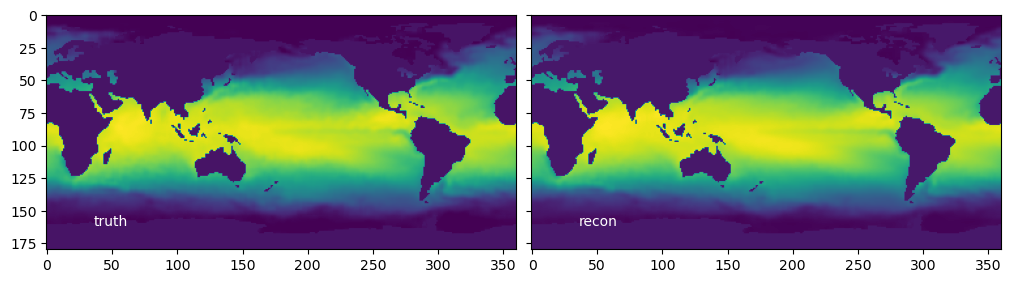

In [12]:
plot_sst(test_ground_truth, test_recons)

### Performance of SHRED as a function of time lag variable

Randomly select 3 sensor locations and set the trajectory length (lags) to (13, 26, 39, 52), corresponding to every quarter of a year of measurements.

In [13]:
lags_arr = [13, 26, 39, 52]
num_sensors = 3
noise_tol =  0

In [14]:
lag_mse = []
for lags in lags_arr:
    train_dataset, valid_dataset, test_dataset = get_dataloader(sc, num_sensors, lags, noise_tol, load_X)
    shred = SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, 
                            verbose=True, patience=5)
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    mse = compute_mse(test_ground_truth, test_recons)
    lag_mse.append(mse)
    print('lags=', lags, 'mse:', mse)

epoch: 1000 valid_error: tensor(0.1237, device='cuda:0'): 100%|████████████████████| 1000/1000 [02:08<00:00,  7.80it/s]


lags= 13 mse: 0.021513332


epoch: 960 valid_error: tensor(0.1124, device='cuda:0'):  96%|█████████████████████ | 959/1000 [02:04<00:05,  7.69it/s]


Model stopped improving with a valid_error: tensor(0.1124, device='cuda:0')
lags= 26 mse: 0.020554077


epoch: 1000 valid_error: tensor(0.1166, device='cuda:0'): 100%|████████████████████| 1000/1000 [02:09<00:00,  7.74it/s]


lags= 39 mse: 0.021021323


epoch: 840 valid_error: tensor(0.1118, device='cuda:0'):  84%|██████████████████▍   | 839/1000 [01:49<00:20,  7.68it/s]


Model stopped improving with a valid_error: tensor(0.1118, device='cuda:0')
lags= 52 mse: 0.020241804


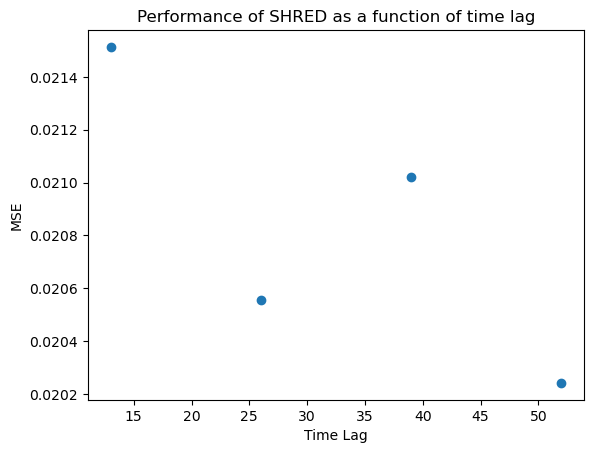

In [15]:
plt.figure()
plt.title('Performance of SHRED as a function of time lag')
plt.ylabel('MSE')
plt.xlabel('Time Lag')
plt.scatter(lags_arr, lag_mse)
plt.show()

### Performance of SHRED as a function of Guassian noise

In [16]:
lags_arr = 52
num_sensors = 3
noise_tols =  [0, 0.25, 0.5, 0.75, 1]

In [17]:
noise_mse = []
for noise_tol in noise_tols:
    train_dataset, valid_dataset, test_dataset = get_dataloader(sc, num_sensors, lags, noise_tol, load_X)
    shred = SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, 
                            verbose=True, patience=5)
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    mse = compute_mse(test_ground_truth, test_recons)
    noise_mse.append(mse)
    print('noise=', noise_tol, 'mse:', mse)

epoch: 1000 valid_error: tensor(0.1093, device='cuda:0'): 100%|████████████████████| 1000/1000 [02:10<00:00,  7.69it/s]


noise= 0 mse: 0.020083627


epoch: 240 valid_error: tensor(0.5790, device='cuda:0'):  24%|█████▎                | 239/1000 [00:31<01:39,  7.64it/s]


Model stopped improving with a valid_error: tensor(0.5790, device='cuda:0')
noise= 0.25 mse: 0.11851371


epoch: 140 valid_error: tensor(0.8354, device='cuda:0'):  14%|███                   | 139/1000 [00:18<01:53,  7.56it/s]


Model stopped improving with a valid_error: tensor(0.8354, device='cuda:0')
noise= 0.5 mse: 0.22778198


epoch: 120 valid_error: tensor(0.9394, device='cuda:0'):  12%|██▌                   | 119/1000 [00:15<01:57,  7.48it/s]


Model stopped improving with a valid_error: tensor(0.9394, device='cuda:0')
noise= 0.75 mse: 0.33317828


epoch: 120 valid_error: tensor(0.9915, device='cuda:0'):  12%|██▌                   | 119/1000 [00:15<01:56,  7.57it/s]


Model stopped improving with a valid_error: tensor(0.9915, device='cuda:0')
noise= 1 mse: 0.43042317


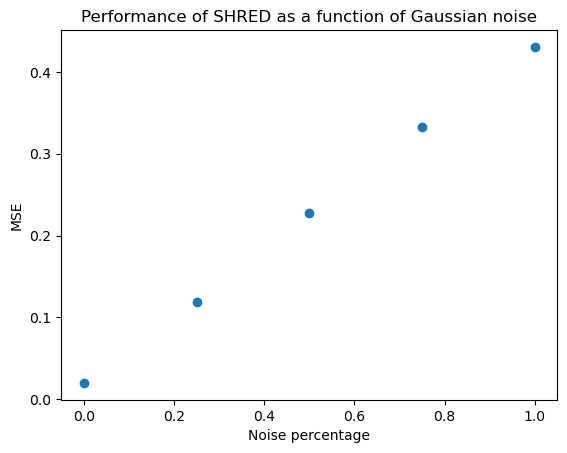

In [18]:
plt.figure()
plt.title('Performance of SHRED as a function of Gaussian noise')
plt.ylabel('MSE')
plt.xlabel('Noise percentage')
plt.scatter(noise_tols, noise_mse)
plt.show()

### Performance of SHRED as a function of the number of sensors

In [19]:
lags_arr = 52
num_sensors = [3, 5, 7, 9, 11]
noise_tol =  0

In [20]:
sensor_mse = []
for num_sensor in num_sensors:
    train_dataset, valid_dataset, test_dataset = get_dataloader(sc, num_sensor, lags, noise_tol, load_X)
    shred = SHRED(num_sensor, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, 
                            verbose=True, patience=5)
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    mse = compute_mse(test_ground_truth, test_recons)
    sensor_mse.append(mse)
    print('num_sensor=', num_sensor, 'mse:', mse)

epoch: 1000 valid_error: tensor(0.1135, device='cuda:0'): 100%|████████████████████| 1000/1000 [02:09<00:00,  7.71it/s]


num_sensor= 3 mse: 0.020164628


epoch: 820 valid_error: tensor(0.1099, device='cuda:0'):  82%|██████████████████    | 819/1000 [01:45<00:23,  7.73it/s]


Model stopped improving with a valid_error: tensor(0.1099, device='cuda:0')
num_sensor= 5 mse: 0.01963091


epoch: 980 valid_error: tensor(0.1083, device='cuda:0'):  98%|█████████████████████▌| 979/1000 [02:06<00:02,  7.72it/s]


Model stopped improving with a valid_error: tensor(0.1083, device='cuda:0')
num_sensor= 7 mse: 0.019693162


epoch: 920 valid_error: tensor(0.1092, device='cuda:0'):  92%|████████████████████▏ | 919/1000 [02:00<00:10,  7.62it/s]


Model stopped improving with a valid_error: tensor(0.1092, device='cuda:0')
num_sensor= 9 mse: 0.01941892


epoch: 840 valid_error: tensor(0.1090, device='cuda:0'):  84%|██████████████████▍   | 839/1000 [01:50<00:21,  7.62it/s]


Model stopped improving with a valid_error: tensor(0.1090, device='cuda:0')
num_sensor= 11 mse: 0.020046445


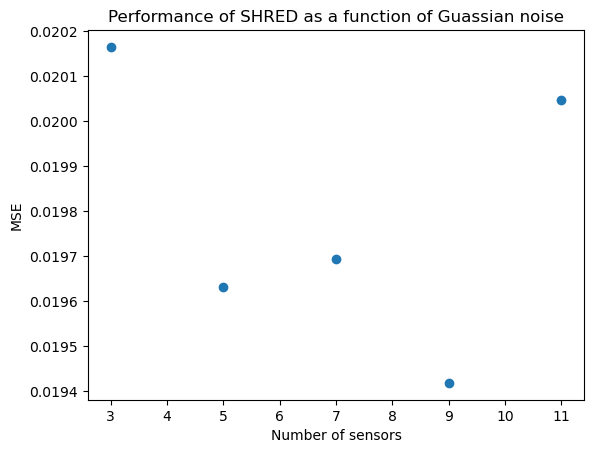

In [21]:
plt.figure()
plt.title('Performance of SHRED as a function of Guassian noise')
plt.ylabel('MSE')
plt.xlabel('Number of sensors')
plt.scatter(num_sensors, sensor_mse)
plt.show()